In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import sequence
import os
import nltk
from nltk.stem.wordnet import WordNetLemmatizer

In [3]:
# People are always telling me "I like my disk space, please don't use all my disk space"
# such a drag
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lucas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lucas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lucas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
df = pd.read_csv("dataset/train.csv")
df_test = pd.read_csv("dataset/test.csv") # Test dataset has no target, we'll need to do a validation split

print('Training Set Shape = {}'.format(df.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))
df.head()

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [44]:
# Largely borrowed from https://www.kaggle.com/code/dhan29/elmo-imdb-text-classification
import re
from nltk.tokenize import ToktokTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

df_prep = df.copy()

#Apply function on review column (yeet anything that isn't a letter, number, or space)
df_prep['text']=df['text'].str.replace(r'[^a-zA-z0-9\s]', '', regex=True)

#Tokenization of text
# tokenizer=ToktokTokenizer()

#set stopwords to english and yeet them too
stopword_list = set(stopwords.words('english'))
df_prep["text"] = df_prep["text"].str.split().apply(lambda x: ' '.join(k for k in x if k.lower() not in stopword_list))


# Initialize the WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

# Define a function to perform lemmatization on a single text

# df_prep["text"] = df_prep["text"].apply(lambda x: " ".join([lemmatizer.lemmatize(word) for word in nltk.word_tokenize(x)]))

# Print the lemmatized DataFrame
print(df_prep.head())



   id keyword location                                               text  \
0   1     NaN      NaN       Deeds Reason earthquake May ALLAH Forgive us   
1   4     NaN      NaN              Forest fire near La Ronge Sask Canada   
2   5     NaN      NaN  residents asked shelter place notified officer...   
3   6     NaN      NaN  13000 people receive wildfires evacuation orde...   
4   7     NaN      NaN  got sent photo Ruby Alaska smoke wildfires pou...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


In [10]:
text = df_prep['text']
target = df_prep['target']


X_train, X_val, y_train, y_val = train_test_split(text, target, test_size=0.2, random_state=42)

In [11]:
X_train.head()

4996    Courageous and honest analysis of need to use ...
3263    ZachZaidman 670TheScore wld b a shame if that ...
4907    Tell BarackObama to rescind medals of honor gi...
2855    Worried about how the CA drought might affect ...
4716    YoungHeroesID Lava Blast amp Power Red Panther...
Name: text, dtype: object

In [12]:
import tensorflow_hub as hub

elmo = hub.load("https://tfhub.dev/google/elmo/2").signatures["default"]

In [60]:
# Use the ELMo model to convert text to vector embeddings
# This was way harder to figure out than it needed to be.
# Side note: this will murder your computer.
import itertools

max_len = 25
batch_size = 128

def embed_elmo(text, signature="default"):
    text_clipped = text.str.split(n=max_len).str[:max_len].str.join(' ')
    n = len(text_clipped)
    embeddings = []
    for i, batch in enumerate(np.array_split(text_clipped.to_numpy(), n//batch_size)):
        print(f"Batch {i}/{n//batch_size}", end="\r")
        # Default signature does mean-pooling of all words
        # It's actually designed for un-tokenized data, I'm not sure if my preprocessing is actually helpful
        batch_out = elmo(tf.constant(batch))[signature]
        embeddings.append(batch_out)
    print()
    return list(itertools.chain(*embeddings))

In [61]:
X_train_embed = embed_elmo(X_train, signature="default")
X_val_embed = embed_elmo(X_val, signature="default")

Batch 46/47
Batch 10/11


In [16]:
# Padding for elmo embeddings (not needed for default)
# pad_seq = np.array(X_train_embed[0].numpy()[-1])
# pad_size = max_len
# def pad(X):
#     return np.array([
#         np.concatenate([X_elem.numpy(), np.repeat([pad_seq], pad_size - X_elem.shape[0], axis=0)]) for X_elem in X
#     ])


In [63]:
# X_train_padded = pad(X_train_embed)
# X_val_padded = pad(X_val_embed)
X_train_padded = np.array([x.numpy() for x in X_train_embed])
X_val_padded = np.array([x.numpy() for x in X_val_embed])
X_train_padded.shape

(6090, 1024)

In [66]:
from tensorflow.keras.layers import Dense, Input, Dropout, SimpleRNN, GRU, LSTM, BatchNormalization, Flatten
from tensorflow.keras import Model, Sequential
# input_text = Input(shape = X_train_padded.shape[1:])
# dropout = Dropout(0.4)(input_text)
# dense = Dense(16, activation='relu')(dropout)
# dropout_2 = Dropout(0.4)(dense)
# dense_2 = Dense(16, activation='relu')(dropout_2)
# pred = Dense(1, activation='sigmoid')(dense_2)
# model = Model(inputs=[input_text], outputs=pred)

model = Sequential([
    Input(shape=(1024,)),
    Dense(128, activation='relu'),
    # GRU(8, return_sequences = True, dropout=0.2, recurrent_dropout=0.2),
    # GRU(8, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, activation="relu"),
    # LSTM(4, dropout=0.3, recurrent_dropout=0.3, activation="tanh", recurrent_activation="sigmoid"),
    # Dense(64, activation='relu'),
    # BatchNormalization(),  # Batch normalization layer
    Dropout(0.5),  # Dropout layer to prevent overfitting
    Dense(16, activation='relu'),
    Dropout(0.5),

    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', "precision", "recall"])
model.summary()

history = model.fit(X_train_padded, 
          y_train,
          validation_data=(X_val_padded, y_val),
          epochs=50,
          batch_size=32)

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_29 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 16)             │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,281 (520.63 KB)

 Trainable params: 133,281 (520.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6728 - loss: 0.5940 - precision: 0.6300 - recall: 0.5796 - val_accuracy: 0.8102 - val_loss: 0.4303 - val_precision: 0.7778 - val_recall: 0.7766
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7840 - loss: 0.4824 - precision: 0.7819 - recall: 0.6657 - val_accuracy: 0.8188 - val_loss: 0.4218 - val_precision: 0.8103 - val_recall: 0.7504
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8043 - loss: 0.4494 - precision: 0.8099 - recall: 0.7127 - val_accuracy: 0.8293 - val_loss: 0.4144 - val_precision: 0.8867 - val_recall: 0.6872
Epoch 4/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8080 - loss: 0.4352 - precision: 0.8289 - recall: 0.7089 - val_accuracy: 0.8234 - val_loss: 0.4174 - val_precision: 0.8626 - val_recall: 0.6965
Epoch 5/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8030 - loss: 0.4508 - precision: 0.8302 - recall: 0.6824 - val_accuracy: 0.8319 - val_loss: 0.

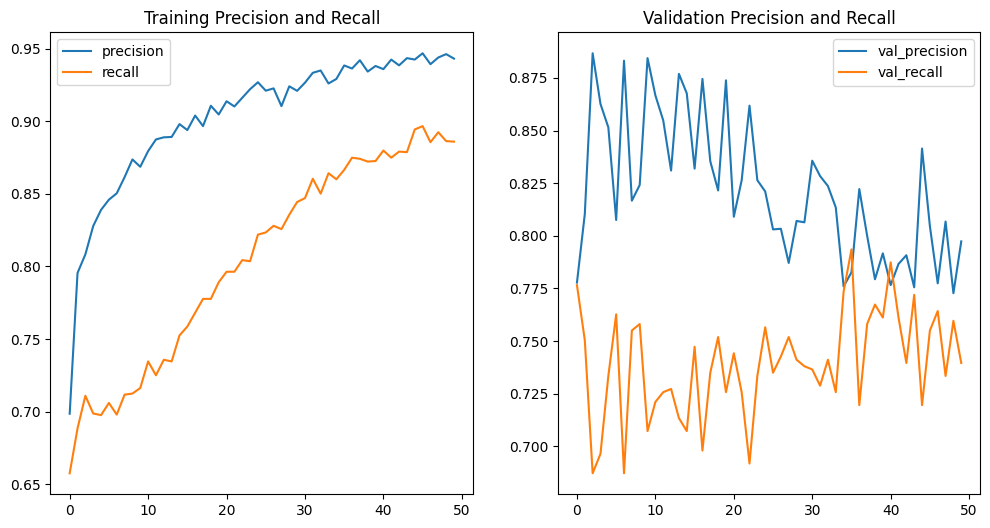

In [68]:
# Plot the training and validation loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
ax = plt.subplot(1, 2, 1)
plt.plot(history.history['precision'])
plt.plot(history.history["recall"])
plt.title('Training Precision and Recall')
plt.legend(['precision', 'recall'])
ax = plt.subplot(1, 2, 2)
plt.plot(history.history['val_precision'])
plt.plot(history.history["val_recall"])
plt.title('Validation Precision and Recall')
plt.legend(['val_precision', 'val_recall'])
plt.show()


In [ ]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall'])

In [59]:
# Test dataset

lstm_one_score = model.evaluate(X_val_padded, y_val)
print("Validation score:", lstm_one_score)


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8144 - loss: 0.4971 - precision: 0.8143 - recall: 0.7366
Validation score: [0.4695078730583191, 0.8200919032096863, 0.8109452724456787, 0.7534668445587158]


In [54]:
lstm_three_score = lstm_big_score

NameError: name 'lstm_big_score' is not defined

In [67]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train_padded, y_train)
score = svc.score(X_val_padded, y_val)
print("Validation score:", score)

Validation score: 0.8371634931057124


In [71]:
y_val_hat = svc.predict(X_val_padded)
df_val = pd.DataFrame({"text": X_val, "target": y_val, "pred": y_val_hat, "correct": y_val == y_val_hat})
df_val.to_csv("SVC_validation.csv")